# FordGoBike Consumer Habits
## by Rachel Strate

## Investigation Overview

In this investigation, I looked at the two consumers of FordGoBike, subscribers and consumers, comparing their consumer habits across four key features: day of the week, time period, ride duration in minutes, and distance.

## Dataset Overview

The data explored the August 2019 FordGoBike System data consisting of 210,563 entries and 14 features, to which I added the 4 key features mentioned above. 

In [68]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [69]:
#loading data
df = pd.read_csv('201908-baywheels-tripdata.csv')


In [70]:
#data wrangling
#Writing a function to change data types.
def dt_type (column):
    df[column] = pd.to_datetime(df[column])
    return
#Instantiating the fuction
dt_type('start_time')
dt_type('end_time')

#inserting day of week column
df.insert(3, 'day_of_week', df.start_time.dt.dayofweek)

#inserting minutes duration column
df.insert(1, 'duration_min', df.duration_sec/60)

#Calculating distance.  Please note this code was found in the Udacity knowledge area.
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df['distance'] = haversine(df['start_station_longitude'],
                          df['start_station_latitude'],
                          df['end_station_longitude'],
                          df['end_station_latitude'])

#Inserting a new column.  Temporarily filling it with the start_time content.
df.insert(4, 'time_slot', df['start_time'])

#Building a function to remove the hour from the datetime.
from datetime import datetime

def time_split(df, column):
    df[column] = df[column].apply(lambda x: datetime.strftime(x,'%H'))
    return df.head(5)

#Instantiating the function
time_split(df, 'time_slot')

#Changing the column to an int data type.
df.time_slot = df.time_slot.astype(int)

#Using a lambda function to update the column with the time category.
col = ['time_slot']
for c in col:
    df['time_slot'] = df[c].apply(lambda x: 'morning' if x>5 and x<12 else 
                             'afternoon' if x>11 and x<18 else 
                             'evening' if x>17 and x<25 else 'late_night')
    
base_color = sb.color_palette()[0]

## Users

Looking at the users from an absolute value point of view we see that subscribers far out number the consumers with the values of 164,928 and 45,635, respectively.  These numbers are a bit hard to comprehend so relative values were calculated and plotted in a pie chart.

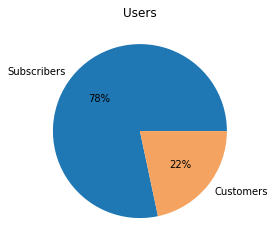

In [71]:
#Calculating proportions to use for visualization in a pie chart.
sub_prop = df.query('user_type == "Subscriber"').user_type.count()/df.shape[0]
cust_prop = df.query('user_type == "Customer"').user_type.count()/df.shape[0]
sub_prop, cust_prop

users = np.array([sub_prop, cust_prop])
users

#Creating the pie chart, adding the percentages for clarity of the difference.
plt.pie(users, labels = ['Subscribers', 'Customers'], autopct='%1.f%%', colors = [base_color, 'sandybrown'])
plt.title('Users');

## Day of Week

The first main feature of interest was day of week where we saw the consumers' interest diverge.  The subscribers were active users in the week with waning interest on the weekends whereas the customers were opposite.

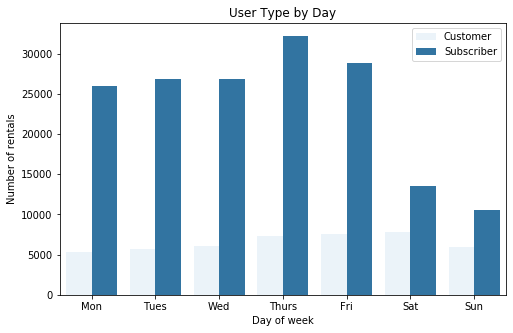

In [72]:
#Users and Day of Week
plt.figure(figsize=[8, 5])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'day_of_week', hue = 'user_type', color = base_color);
plt.xlabel('Day of week')
plt.ylabel('Number of rentals')
plt.title('User Type by Day')
plt.legend(['Customer','Subscriber'])
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);

## Time Period

Delving a bit further into the day of week we add in the variable of time period.  When time period was looked at in an univariate visualization morning and afternoon looked essentially equal.  But by looking at the time periods from a bivariate point of view we see that mornings are definitely the most active period.

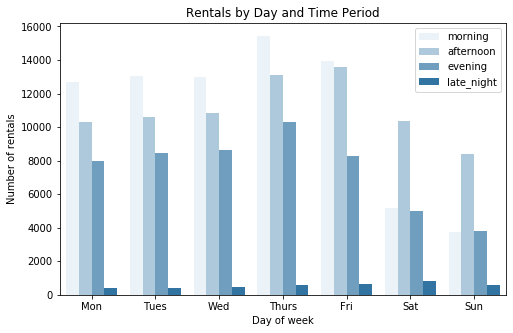

In [73]:
df.time_slot= pd.Categorical(df.time_slot, categories=['morning', 'afternoon', 'evening', 'late_night' ], ordered=True)

#Day and Time of Day
plt.figure(figsize=[8, 5])

sb.countplot(data = df, x = 'day_of_week', hue = 'time_slot', color = base_color);
plt.legend(title = '')
plt.xlabel('Day of week')
plt.ylabel('Number of rentals')
plt.title('Rentals by Day and Time Period')
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);

## Duration

Plotting the distribution was quite fascinating due to the visual provided in a violin chart. We see the inner box chart shows the average duration slightly more for a customer but what was most interesting was the differing distributions were subscribers had a sharp peak and the customer distribution was more gradual.

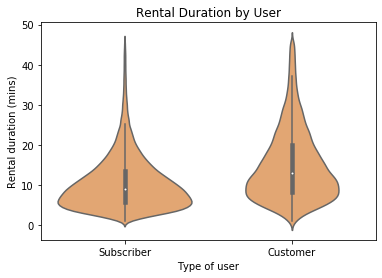

In [74]:
sb.violinplot(data = df_no_outliers, x = 'user_type', y = 'duration_min', color = 'sandybrown')
plt.xlabel('Type of user')
plt.ylabel('Rental duration (mins)')
plt.title('Rental Duration by User');

## Multivariate Visualizations

The habits of the consumers become even clearer when looking at 3 variables.

The first visualization highlights the distance to duration by user type.  The subscriber duration distribution peak from the previous violin plot can be seen as well as the more gradual distribution of the customers.  We also see that regardless of duration the distance doesn't increase drastically.  Part of this would be due to the fact that this is the distance between stations rather than full distance travelled

The second visualization is another slice of the duration but this time with day of week, building upon the early chart that listed consumer usage by day.  This provides another view of the customers enjoying their weekend rides moreso than the subscribers.

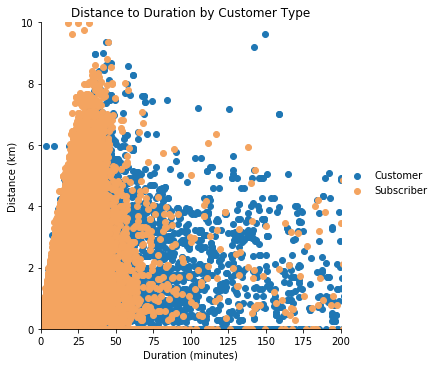

In [75]:
#Original df
g = sb.FacetGrid(data = df, hue = 'user_type', height = 5, palette = [base_color, 'sandybrown'])
g.map(plt.scatter,'duration_min', 'distance')
plt.ylim(0,10)
plt.xlim(0,200)
plt.title('Distance to Duration by Customer Type')
plt.ylabel('Distance (km)')
plt.xlabel('Duration (minutes)')
g.add_legend(title = '');

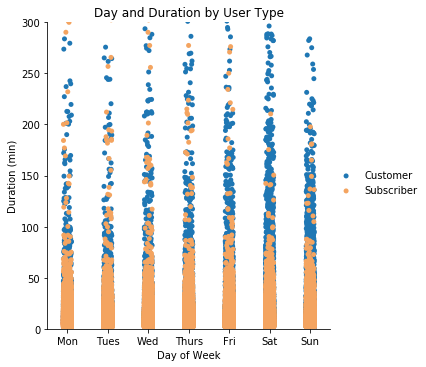

In [76]:
g = sb.FacetGrid(data = df, hue = 'user_type', height = 5, palette = [base_color, 'sandybrown'])
g.map(sb.stripplot,'day_of_week', 'duration_min', dodge = True)
plt.ylim(0,300)
plt.title('Day and Duration by User Type')
plt.ylabel('Duration (min)')
plt.xlabel('Day of Week')
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
g.add_legend(title = '');

Overall, we see that the habits of the different users are very different and that FordGoBike has two distinct consumer bases.  The subscribers use the bikes possibly for communiting as the trips are mainly during the week days, are short in duration and distance, plus dropoff in use during the weekend.  The consumer rental interest peaks from Friday onwards and even though the distance travelled isn't far they will use the rental for a longer duration. 